In [1]:
# -----------------------------------------------------------------------------
# 1. Imports and API wiring
# -----------------------------------------------------------------------------

import os, sys, math
import numpy as np
import torch
import matplotlib.pyplot as plt
import importlib

# Ensure local package is importable (assumes this notebook is in project root)
root = os.getcwd()
if root not in sys.path:
    sys.path.insert(0, root)

# Imports from AdaPID and GuidedPID APIs
adapid = importlib.import_module("adapid_torch")
guided = importlib.import_module("guided_torch")
CaseA  = importlib.import_module("CaseA")

print("Ada API:", adapid.__file__)
print("Guided API:", getattr(guided, "__file__", None))
print("CaseA API:", getattr(CaseA, "__file__", None))

# Convenience aliases from CaseA API
SnapshotConfig                = CaseA.SnapshotConfig
simulate_caseA_with_snapshots = CaseA.simulate_caseA_with_snapshots
build_corridor_walls          = CaseA.build_corridor_walls

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Ada API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/adapid_torch/__init__.py
Guided API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/guided_torch/__init__.py
CaseA API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/CaseA/__init__.py
Using device: cpu


In [2]:
# -----------------------------------------------------------------------------
# 2. Target GMMs: 2-mode and triangular 3-mode (fixed in space)
#    Start at origin; guides go to CM of 2-mode GMM
# -----------------------------------------------------------------------------

rng = np.random.default_rng(1234)

def make_gmm_params_2mode():
    """Two modes arranged roughly along the corridor, different weights/variances."""
    mu = np.array([[2.0, -0.25],
                   [3.0,  0.35]], dtype=np.float32)
    cov = np.array([[[0.10, 0.0],
                     [0.0,  0.04]],
                    [[0.05, 0.0],
                     [0.0,  0.08]]], dtype=np.float32)
    w = np.array([0.6, 0.4], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w

def make_gmm_params_3mode_triangular():
    """Three modes in a triangular configuration, not colinear."""
    mu = np.array([[2.0,  0.0],
                   [2.8,  0.5],
                   [2.8, -0.5]], dtype=np.float32)
    cov = np.array([[[0.06, 0.0],
                     [0.0,  0.05]],
                    [[0.04, 0.0],
                     [0.0,  0.04]],
                    [[0.09, 0.0],
                     [0.0,  0.07]]], dtype=np.float32)
    w = np.array([0.4, 0.35, 0.25], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w

mu2_np, cov2_np, w2_np = make_gmm_params_2mode()
mu3_np, cov3_np, w3_np = make_gmm_params_3mode_triangular()

MU2  = torch.from_numpy(mu2_np).to(device)
COV2 = torch.from_numpy(cov2_np).to(device)
W2   = torch.from_numpy(w2_np).to(device)

MU3  = torch.from_numpy(mu3_np).to(device)
COV3 = torch.from_numpy(cov3_np).to(device)
W3   = torch.from_numpy(w3_np).to(device)

gmm_2 = adapid.GMMTorch(MU2, COV2, W2).to(device)
gmm_3 = adapid.GMMTorch(MU3, COV3, W3).to(device)

gmms = {"2mode": gmm_2, "3mode": gmm_3}
gmm_params = {
    "2mode": (mu2_np, cov2_np, w2_np),
    "3mode": (mu3_np, cov3_np, w3_np),
}

print("Target GMMs built:")
for name, g in gmms.items():
    print(f"  {name}: N={g.MU.shape[0]}, d={g.MU.shape[1]}")

# 1) All particles start at origin
start_pt = np.array([0.0, 0.0], dtype=float)

# 3) Guides ν(t) end at center of mass of the 2-mode GMM
cm_2   = (mu2_np * w2_np[:, None]).sum(axis=0)
end_pt = cm_2.astype(float)

print("Start point:", start_pt)
print("End point (center of mass of 2-mode GMM):", end_pt)

Target GMMs built:
  2mode: N=2, d=2
  3mode: N=3, d=2
Start point: [0. 0.]
End point (center of mass of 2-mode GMM): [ 2.4000001  -0.01000001]


In [3]:
# -----------------------------------------------------------------------------
# 3. Geometry: straight, strong V-neck, and strong S-tunnel
# -----------------------------------------------------------------------------

def build_frame(start: np.ndarray, end: np.ndarray):
    v = end - start
    L = float(np.linalg.norm(v))
    if L <= 0:
        raise ValueError("start and end points are identical.")
    e = v / L
    n = np.array([-e[1], e[0]])  # perpendicular
    return e, n, L

e_axis, n_axis, L_axis = build_frame(start_pt, end_pt)

def make_centerline_straight(start, end):
    def c(s: float) -> np.ndarray:
        s = float(np.clip(s, 0.0, 1.0))
        return (1.0 - s) * start + s * end
    return c

def make_centerline_V(start, end, amp: float = 1.5):
    """Strong V-shape: max transverse offset ≈ amp (default 1.5)."""
    e, n, L = build_frame(start, end)

    def c(s: float) -> np.ndarray:
        s = float(np.clip(s, 0.0, 1.0))
        base = start + s * (end - start)
        phi = 1.0 - abs(2.0 * s - 1.0)  # peak at s=0.5
        offset = -amp * phi
        return base + offset * n

    return c

def make_centerline_S(start, end, amp: float = 1.5):
    """Strong S-shape: sinusoidal transverse excursion with max |offset|≈amp."""
    e, n, L = build_frame(start, end)

    def c(s: float) -> np.ndarray:
        s = float(np.clip(s, 0.0, 1.0))
        base = start + s * (end - start)
        offset = amp * np.sin(2.0 * np.pi * s)
        return base + offset * n

    return c

centerline_straight = make_centerline_straight(start_pt, end_pt)
centerline_V        = make_centerline_V(start_pt, end_pt, amp=1.5)
centerline_S        = make_centerline_S(start_pt, end_pt, amp=1.5)

S_plot = 128
s_grid = np.linspace(0.0, 1.0, S_plot)
centerline_lin_arr = np.stack([centerline_straight(s) for s in s_grid], axis=0)
centerline_v_arr   = np.stack([centerline_V(s)        for s in s_grid], axis=0)
centerline_s_arr   = np.stack([centerline_S(s)        for s in s_grid], axis=0)

print("Centerlines (straight, V, S) built with transverse amplitude ≈1.5.")

Centerlines (straight, V, S) built with transverse amplitude ≈1.5.


In [4]:
# -----------------------------------------------------------------------------
# 4. GMM sampling utilities and precomputed target clouds
# -----------------------------------------------------------------------------

def sample_gmm_from_params(mu_np, cov_np, w_np, n_samples, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_np  = np.asarray(mu_np, dtype=float)
    cov_np = np.asarray(cov_np, dtype=float)
    w_np   = np.asarray(w_np, dtype=float)
    w_np   = w_np / w_np.sum()
    N, d = mu_np.shape
    comps = rng.choice(N, size=n_samples, p=w_np)
    X = np.zeros((n_samples, d), dtype=float)
    for j in range(N):
        idx = np.where(comps == j)[0]
        if idx.size == 0:
            continue
        X[idx, :] = rng.multivariate_normal(mu_np[j], cov_np[j], size=idx.size)
    return X

N_tar = 4000
mu2_np, cov2_np, w2_np = gmm_params["2mode"]
mu3_np, cov3_np, w3_np = gmm_params["3mode"]

X_tar_2 = sample_gmm_from_params(mu2_np, cov2_np, w2_np, N_tar, rng)
X_tar_3 = sample_gmm_from_params(mu3_np, cov3_np, w3_np, N_tar, rng)

print("Target sample clouds:", X_tar_2.shape, X_tar_3.shape)

Target sample clouds: (4000, 2) (4000, 2)


In [5]:
# -----------------------------------------------------------------------------
# 5. β-profiles, speed profiles, and ν(t) builders
# -----------------------------------------------------------------------------

def make_beta_const(beta_val: float):
    def beta_fn(t: float) -> float:
        return float(beta_val)
    return beta_fn

def make_beta_S_scaled(gamma: float, beta_base: float = 1.5):
    def beta_fn(t: float) -> float:
        return float(gamma * beta_base)
    return beta_fn

def make_nu_from_centerline(centerline_fn):
    def nu_t(t: float) -> np.ndarray:
        s = float(np.clip(t, 0.0, 1.0))
        return centerline_fn(s)
    return nu_t

def nu_S(t: float) -> np.ndarray:
    return centerline_S(float(np.clip(t, 0.0, 1.0)))

In [27]:
# -----------------------------------------------------------------------------
# 6. Schedule builder (ν(0)=start, ν(1)=end) and common simulation configuration
# -----------------------------------------------------------------------------

def build_schedule_from_nu_beta(
    nu_fn, beta_fn,
    splits: np.ndarray,
    d: int,
    device: torch.device,
) -> guided.GuidedPWCSchedule:
    """
    Build GuidedPWCSchedule with ν-values chosen so that
      ν(0) = ν_fn(0)  and  ν(1^-) = ν_fn(1)
    under the piecewise-constant NuPWC convention:
      ν(t) = values[k] for t in [splits[k], splits[k+1]).
    We do this by:
      - setting values[0]   = ν_fn(0),
      - setting values[-1]  = ν_fn(1),
      - using midpoints for interior segments.
    β_k are still sampled at midpoints.
    """
    splits = np.asarray(splits, dtype=float)
    K = len(splits) - 1

    betas   = np.zeros(K, dtype=float)
    nu_vals = np.zeros((K, d), dtype=float)

    # First segment: anchor exactly at t=0
    nu_vals[0, :] = nu_fn(0.0)

    # Interior segments (if any)
    for k in range(1, K - 1):
        t_mid = 0.5 * (splits[k] + splits[k + 1])
        nu_vals[k, :] = nu_fn(t_mid)

    # Last segment: anchor exactly at t=1
    if K > 1:
        nu_vals[K - 1, :] = nu_fn(1.0)

    # β-values at midpoints (all segments)
    for k in range(K):
        t_mid = 0.5 * (splits[k] + splits[k + 1])
        betas[k] = beta_fn(t_mid)

    sched = guided.GuidedPWCSchedule.build(
        betas=betas,
        splits=splits,
        nu_values=nu_vals,
        d=d,
        device=device,
    )
    return sched

splits = np.linspace(0.0, 1.0, 9)

M_samples = 4000
snap_cfg  = SnapshotConfig(T=1500, n_save=9)

In [28]:
# -----------------------------------------------------------------------------
# 7. Case A1: Geometry flexibility (straight, V, S), constant β and speed
# -----------------------------------------------------------------------------

nu_straight = make_nu_from_centerline(centerline_straight)
nu_V_base   = make_nu_from_centerline(centerline_V)
nu_S_base   = make_nu_from_centerline(centerline_S)

beta_geom_val = 5.0
beta_geom     = make_beta_const(beta_geom_val)

geom_names = ["straight", "V", "S"]
geom_nu_fns = {
    "straight": nu_straight,
    "V":        nu_V_base,
    "S":        nu_S_base,
}
geom_centerlines = {
    "straight": centerline_lin_arr,
    "V":        centerline_v_arr,
    "S":        centerline_s_arr,
}

schedules_geom = {}
for gname in geom_names:
    nu_fn = geom_nu_fns[gname]
    sched = build_schedule_from_nu_beta(nu_fn, beta_geom, splits, d=2, device=device)
    schedules_geom[gname] = sched

print("Geometry schedules built for:", geom_names)

snaps_geom = {"2mode": {}, "3mode": {}}

for target_name, gmm in gmms.items():
    for gname in geom_names:
        sched = schedules_geom[gname]
        seed = 5 + hash((target_name, gname)) % 1000
        print(f"[A1] Simulating geometry={gname}, target={target_name}, seed={seed}...")
        snaps_geom[target_name][gname] = simulate_caseA_with_snapshots(
            sched, gmm, M=M_samples, snap_cfg=snap_cfg,
            seed=seed, device=device,
        )

print("Case A1 simulations done.")

Geometry schedules built for: ['straight', 'V', 'S']
[A1] Simulating geometry=straight, target=2mode, seed=1002...
[A1] Simulating geometry=V, target=2mode, seed=447...
[A1] Simulating geometry=S, target=2mode, seed=186...
[A1] Simulating geometry=straight, target=3mode, seed=755...
[A1] Simulating geometry=V, target=3mode, seed=200...
[A1] Simulating geometry=S, target=3mode, seed=427...
Case A1 simulations done.


In [29]:
# -----------------------------------------------------------------------------
# 8. Case A2: Confinement flexibility via β(t) on fixed S-tunnel ν(t)
# -----------------------------------------------------------------------------

beta_scales_S = [1.0, 3.0, 5.0, 7.0]

schedules_S = {}
for gamma in beta_scales_S:
    beta_fn = make_beta_S_scaled(gamma, beta_base=1.5)
    sched   = build_schedule_from_nu_beta(nu_S, beta_fn, splits, d=2, device=device)
    schedules_S[gamma] = sched

print("S-tunnel schedules built for beta scales:", beta_scales_S)

snaps_S = {"2mode": {}, "3mode": {}}

for target_name, gmm in gmms.items():
    for gamma in beta_scales_S:
        seed = 10 + int(100 * gamma) + (0 if target_name == "2mode" else 1)
        print(f"[A2] Simulating S-tunnel, target={target_name}, beta_scale={gamma}, seed={seed}...")
        sched = schedules_S[gamma]
        snaps_S[target_name][gamma] = simulate_caseA_with_snapshots(
            sched, gmm, M=M_samples, snap_cfg=snap_cfg,
            seed=seed, device=device,
        )

print("Case A2 simulations done.")

S-tunnel schedules built for beta scales: [1.0, 3.0, 5.0, 7.0]
[A2] Simulating S-tunnel, target=2mode, beta_scale=1.0, seed=110...
[A2] Simulating S-tunnel, target=2mode, beta_scale=3.0, seed=310...
[A2] Simulating S-tunnel, target=2mode, beta_scale=5.0, seed=510...
[A2] Simulating S-tunnel, target=2mode, beta_scale=7.0, seed=710...
[A2] Simulating S-tunnel, target=3mode, beta_scale=1.0, seed=111...
[A2] Simulating S-tunnel, target=3mode, beta_scale=3.0, seed=311...
[A2] Simulating S-tunnel, target=3mode, beta_scale=5.0, seed=511...
[A2] Simulating S-tunnel, target=3mode, beta_scale=7.0, seed=711...
Case A2 simulations done.


In [30]:
# -----------------------------------------------------------------------------
# 9. Case A3: Temporal flexibility via cutoff s_max on V-neck ν(t)
# -----------------------------------------------------------------------------

def make_nu_V_cutoff(s_max: float):
    s_max = float(np.clip(s_max, 0.0, 1.0))
    def nu_t(t: float) -> np.ndarray:
        t = float(np.clip(t, 0.0, 1.0))
        s = min(t, s_max)
        return centerline_V(s)
    return nu_t

cutoffs_V = [1.0, 0.5, 0.0]

beta_V_const = make_beta_const(20.0)

schedules_V = {}
for c in cutoffs_V:
    nu_fn = make_nu_V_cutoff(c)
    sched = build_schedule_from_nu_beta(nu_fn, beta_V_const, splits, d=2, device=device)
    schedules_V[c] = sched

print("V-neck schedules built for cutoffs (s_max):", cutoffs_V)

snaps_V = {"2mode": {}, "3mode": {}}

for target_name, gmm in gmms.items():
    for c in cutoffs_V:
        seed = 20 + int(100 * c) + (0 if target_name == "2mode" else 1)
        print(f"[A3] Simulating V-neck, target={target_name}, cutoff s_max={c}, seed={seed}...")
        sched = schedules_V[c]
        snaps_V[target_name][c] = simulate_caseA_with_snapshots(
            sched, gmm, M=M_samples, snap_cfg=snap_cfg,
            seed=seed, device=device,
        )

print("Case A3 simulations done.")

V-neck schedules built for cutoffs (s_max): [1.0, 0.5, 0.0]
[A3] Simulating V-neck, target=2mode, cutoff s_max=1.0, seed=120...
[A3] Simulating V-neck, target=2mode, cutoff s_max=0.5, seed=70...
[A3] Simulating V-neck, target=2mode, cutoff s_max=0.0, seed=20...
[A3] Simulating V-neck, target=3mode, cutoff s_max=1.0, seed=121...
[A3] Simulating V-neck, target=3mode, cutoff s_max=0.5, seed=71...
[A3] Simulating V-neck, target=3mode, cutoff s_max=0.0, seed=21...
Case A3 simulations done.


In [31]:
# -----------------------------------------------------------------------------
# 10. Helpers: prepend t = 0⁺ snapshot, axis limits
# -----------------------------------------------------------------------------

def prepend_initial_snapshot(sched, snaps_list, M):
    X0 = np.zeros((M, 2), dtype=np.float32)
    with torch.no_grad():
        nu0 = sched.nu_sched.value(0.0).cpu().numpy()
    init_snap = {"t": 0.0, "X": X0, "nu": nu0}
    return [init_snap] + list(snaps_list)

def get_axis_limits(snaps_list, X_tar):
    xs = [s["X"][:, 0] for s in snaps_list] + [X_tar[:, 0]]
    ys = [s["X"][:, 1] for s in snaps_list] + [X_tar[:, 1]]
    x_min = float(min(np.min(a) for a in xs))
    x_max = float(max(np.max(a) for a in xs))
    y_min = float(min(np.min(a) for a in ys))
    y_max = float(max(np.max(a) for a in ys))
    dx = x_max - x_min
    dy = y_max - y_min
    pad_x = 0.05 * (dx if dx > 0 else 1.0)
    pad_y = 0.05 * (dy if dy > 0 else 1.0)
    return x_min - pad_x, x_max + pad_x, y_min - pad_y, y_max + pad_y

snaps_geom_0 = {"2mode": {}, "3mode": {}}
for target_name in gmms.keys():
    for gname in geom_names:
        sched = schedules_geom[gname]
        snaps_geom_0[target_name][gname] = prepend_initial_snapshot(
            sched, snaps_geom[target_name][gname], M_samples
        )

snaps_S_0 = {"2mode": {}, "3mode": {}}
for target_name in gmms.keys():
    for gamma in beta_scales_S:
        sched = schedules_S[gamma]
        snaps_S_0[target_name][gamma] = prepend_initial_snapshot(
            sched, snaps_S[target_name][gamma], M_samples
        )

snaps_V_0 = {"2mode": {}, "3mode": {}}
for target_name in gmms.keys():
    for c in cutoffs_V:
        sched = schedules_V[c]
        snaps_V_0[target_name][c] = prepend_initial_snapshot(
            sched, snaps_V[target_name][c], M_samples
        )

print("t = 0⁺ snapshots added for all families.")

t = 0⁺ snapshots added for all families.


In [32]:
# -----------------------------------------------------------------------------
# 11. Plotting: guidance, empirical mean, covariance ellipse
# -----------------------------------------------------------------------------

from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, mean, cov, nsig: float = 1.0):
    cov = np.asarray(cov, dtype=float)
    if cov.shape != (2, 2):
        return
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    width  = 2.0 * nsig * np.sqrt(max(vals[0], 0.0))
    height = 2.0 * nsig * np.sqrt(max(vals[1], 0.0))
    if not np.isfinite(width) or not np.isfinite(height):
        return
    ell = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=theta,
        edgecolor="magenta",
        facecolor="none",
        linestyle=":",
        linewidth=1.0,
        alpha=0.9,
    )
    ax.add_patch(ell)

def plot_snapshots_multirow(
    snaps_by_profile,
    X_tar,
    centerline_default,
    row_labels,
    title_prefix,
    filename,
    centerlines_by_row=None,
):
    n_rows = len(snaps_by_profile)
    if n_rows == 0:
        return
    n_panels = len(snaps_by_profile[0])
    if centerlines_by_row is None:
        centerlines_by_row = [centerline_default for _ in range(n_rows)]
    all_snaps_flat = [snap for row in snaps_by_profile for snap in row]
    x_min, x_max, y_min, y_max = get_axis_limits(all_snaps_flat, X_tar)
    fig, axs = plt.subplots(
        n_rows, n_panels,
        figsize=(3.0 * n_panels, 3.0 * n_rows),
        squeeze=False,
        sharex=True,
        sharey=True,
    )
    for i_row, row_snaps in enumerate(snaps_by_profile):
        cl = centerlines_by_row[i_row]
        for j, snap in enumerate(row_snaps):
            ax = axs[i_row, j]
            t  = snap["t"]
            X  = snap["X"]
            nu = snap["nu"]
            ax.scatter(X_tar[:, 0], X_tar[:, 1], s=3, alpha=0.25, color="0.7")
            ax.scatter(X[:, 0], X[:, 1], s=2, alpha=0.6)
            ax.plot(cl[:, 0], cl[:, 1], "k--", lw=1.0)
            ax.scatter([nu[0]], [nu[1]], marker="x", color="red", s=50, linewidths=1.5)
            if X.shape[0] > 1:
                mu_emp  = X.mean(axis=0)
                cov_emp = np.cov(X.T)
                ax.scatter(
                    [mu_emp[0]], [mu_emp[1]],
                    marker="*",
                    color="magenta",
                    s=70,
                    alpha=0.9,
                    linewidths=0.5,
                )
                plot_cov_ellipse(ax, mu_emp, cov_emp, nsig=1.0)
            if i_row == 0:
                ax.set_title(f"t={t:.2f}")
            ax.set_aspect("equal", "box")
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.grid(alpha=0.2)
        axs[i_row, 0].set_ylabel(row_labels[i_row])
    axs[-1, 0].set_xlabel("x")
    fig.suptitle(title_prefix, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    out_dir = os.path.join(root, "results_caseA")
    os.makedirs(out_dir, exist_ok=True)
    fig_path = os.path.join(out_dir, filename)
    fig.savefig(fig_path, dpi=200)
    plt.show()
    print("Saved figure to:", fig_path)

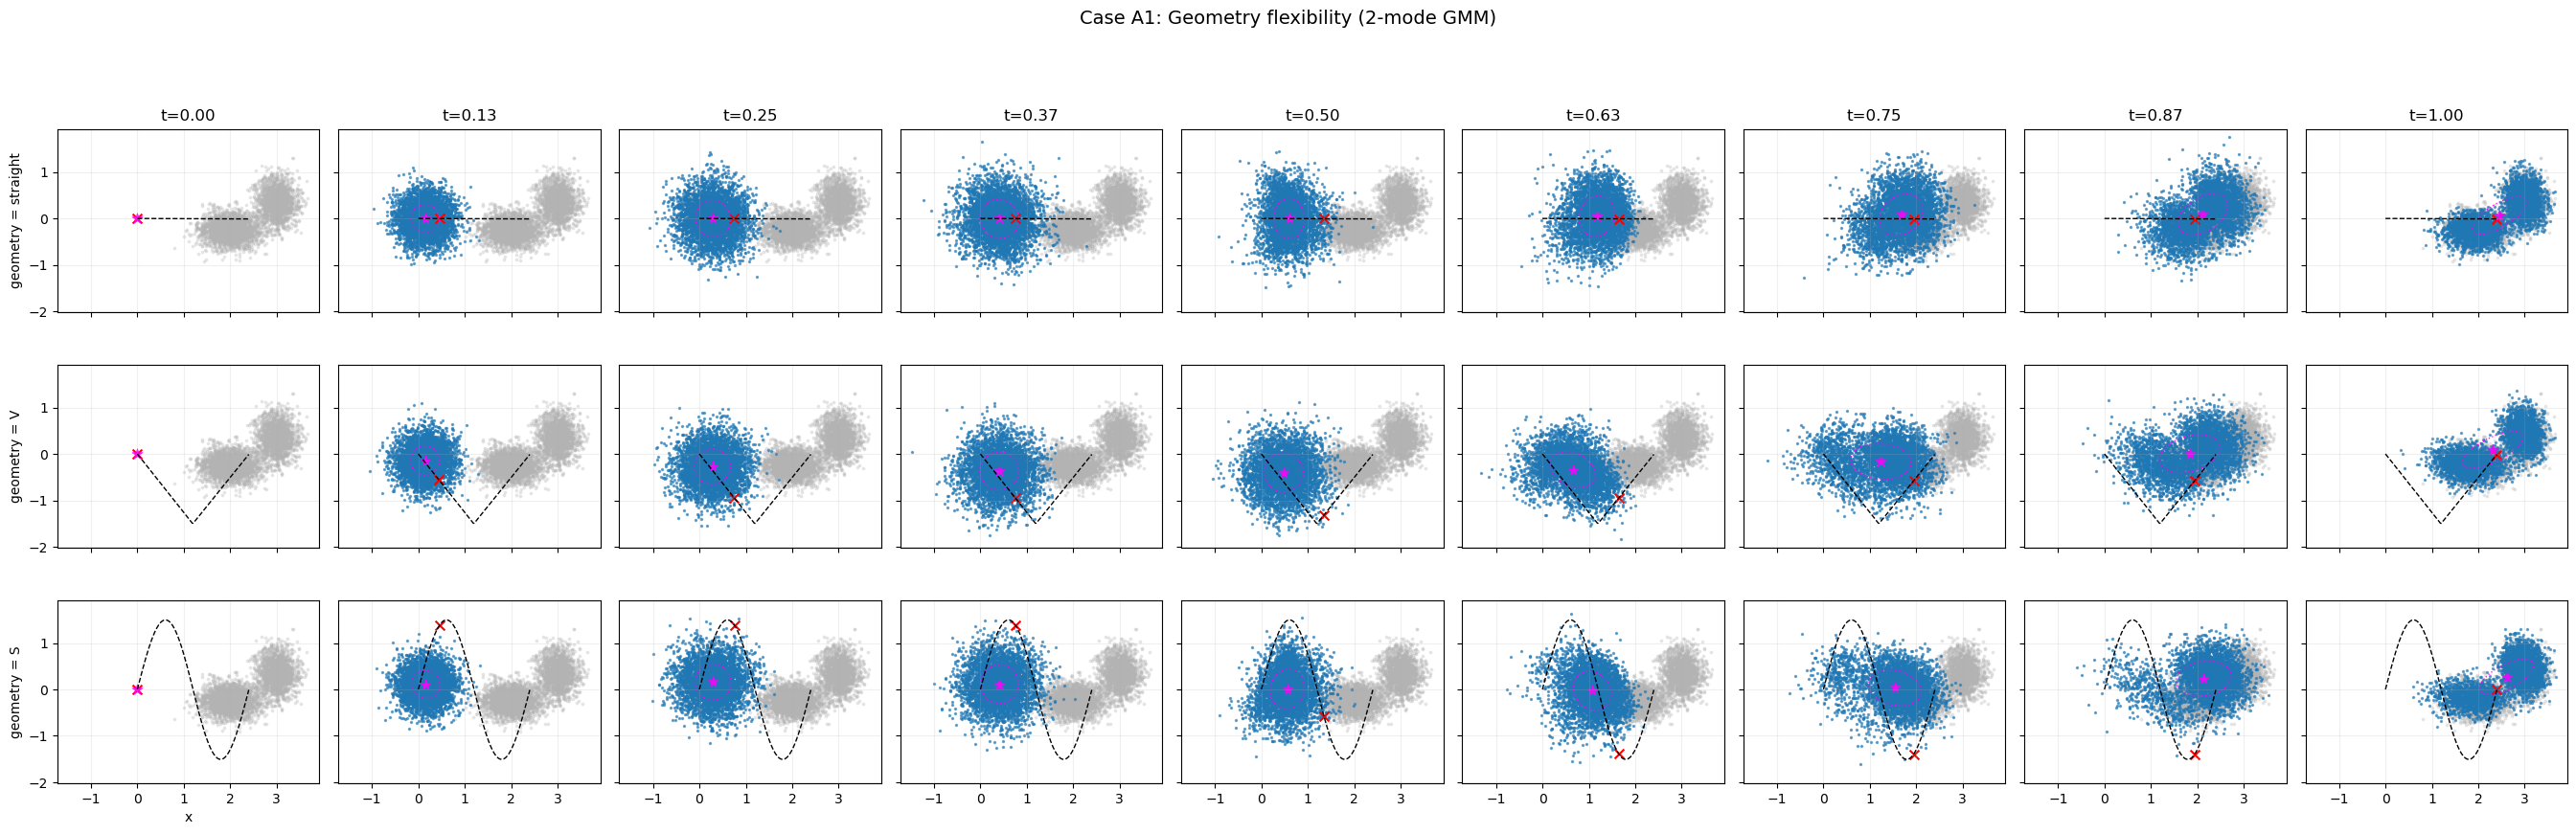

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A1_geometry_2mode.png


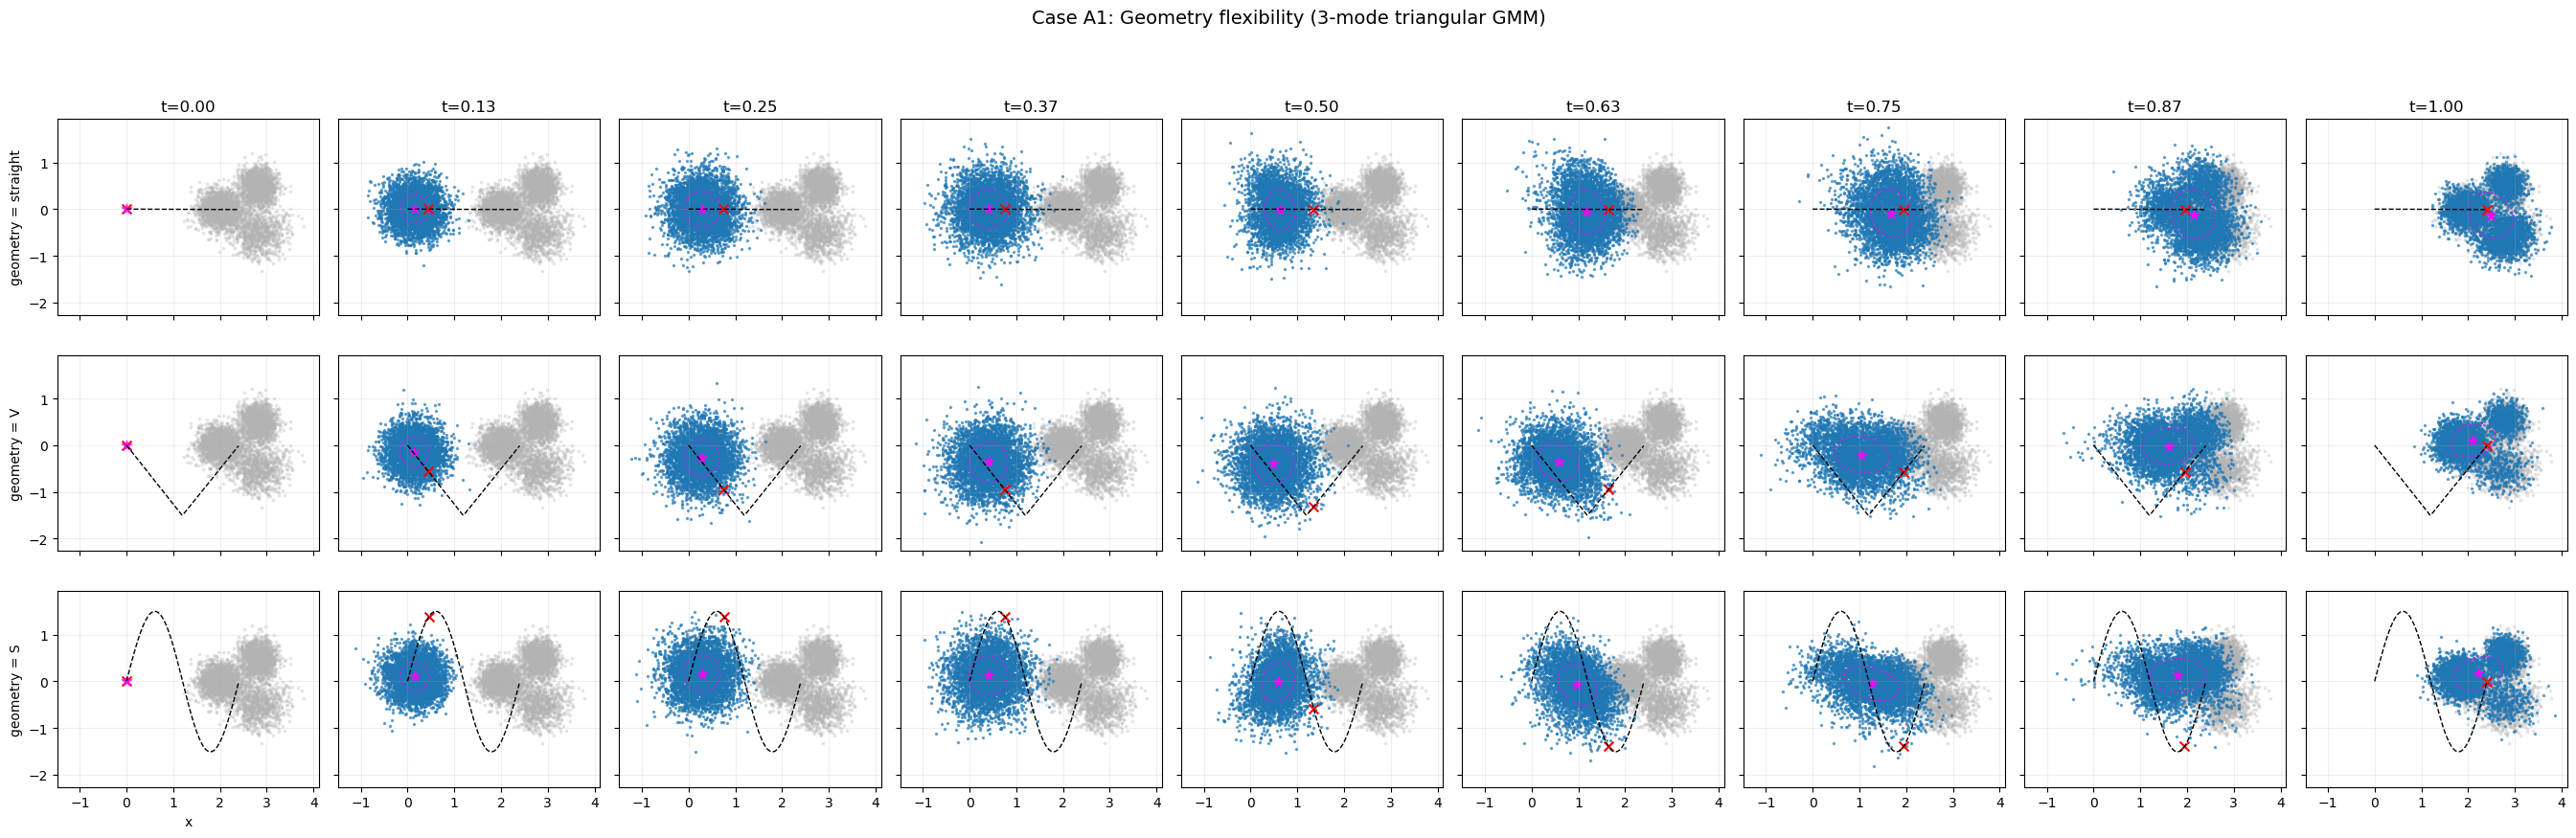

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A1_geometry_3mode.png


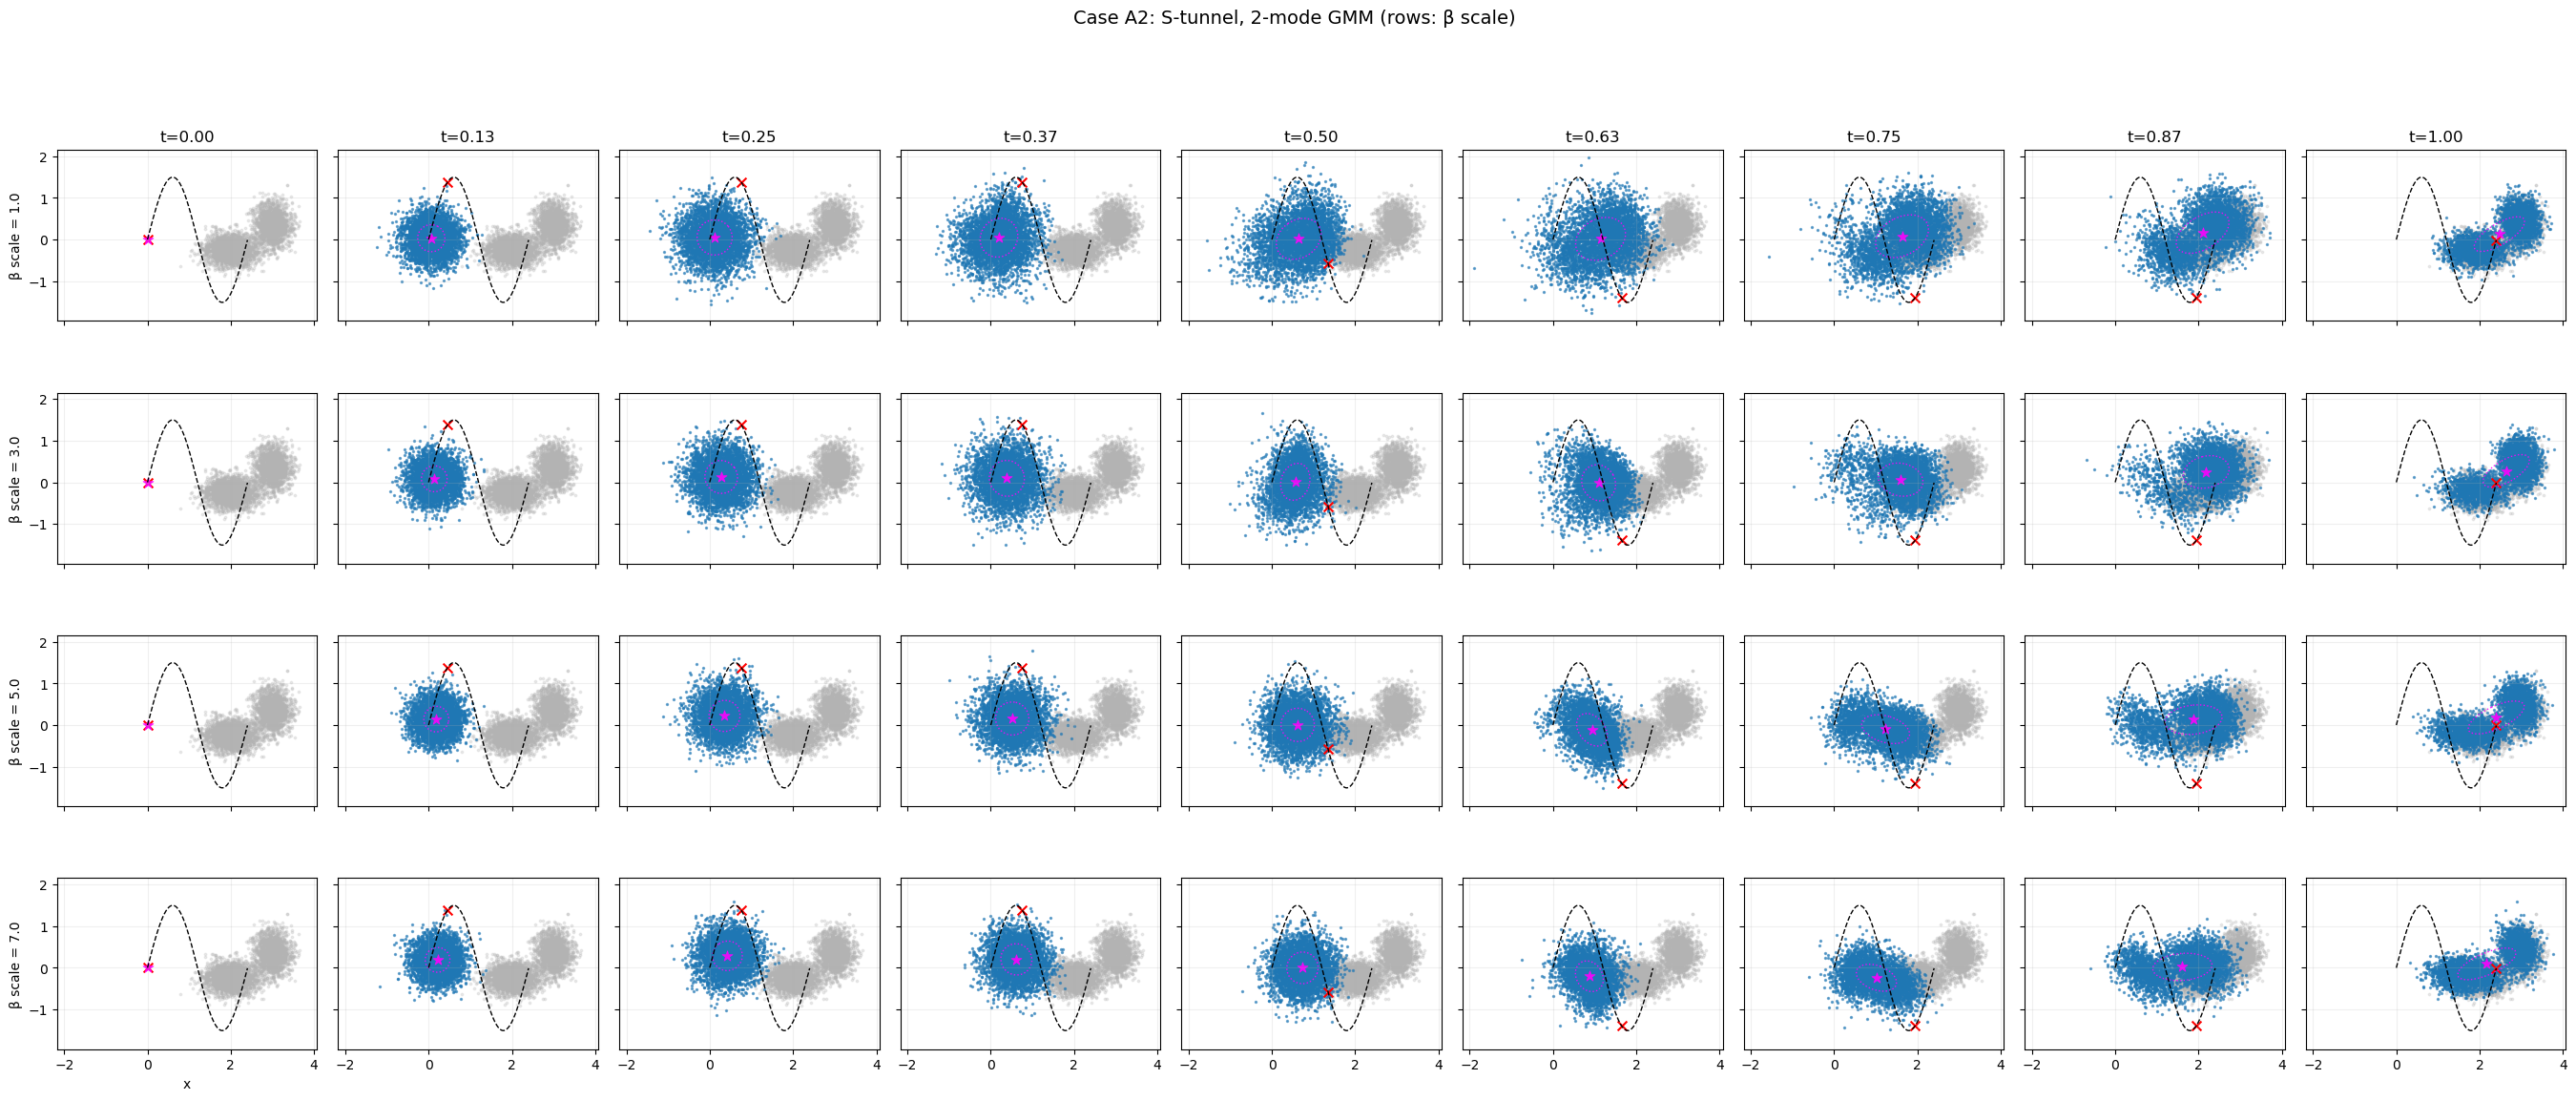

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A2_S_2mode.png


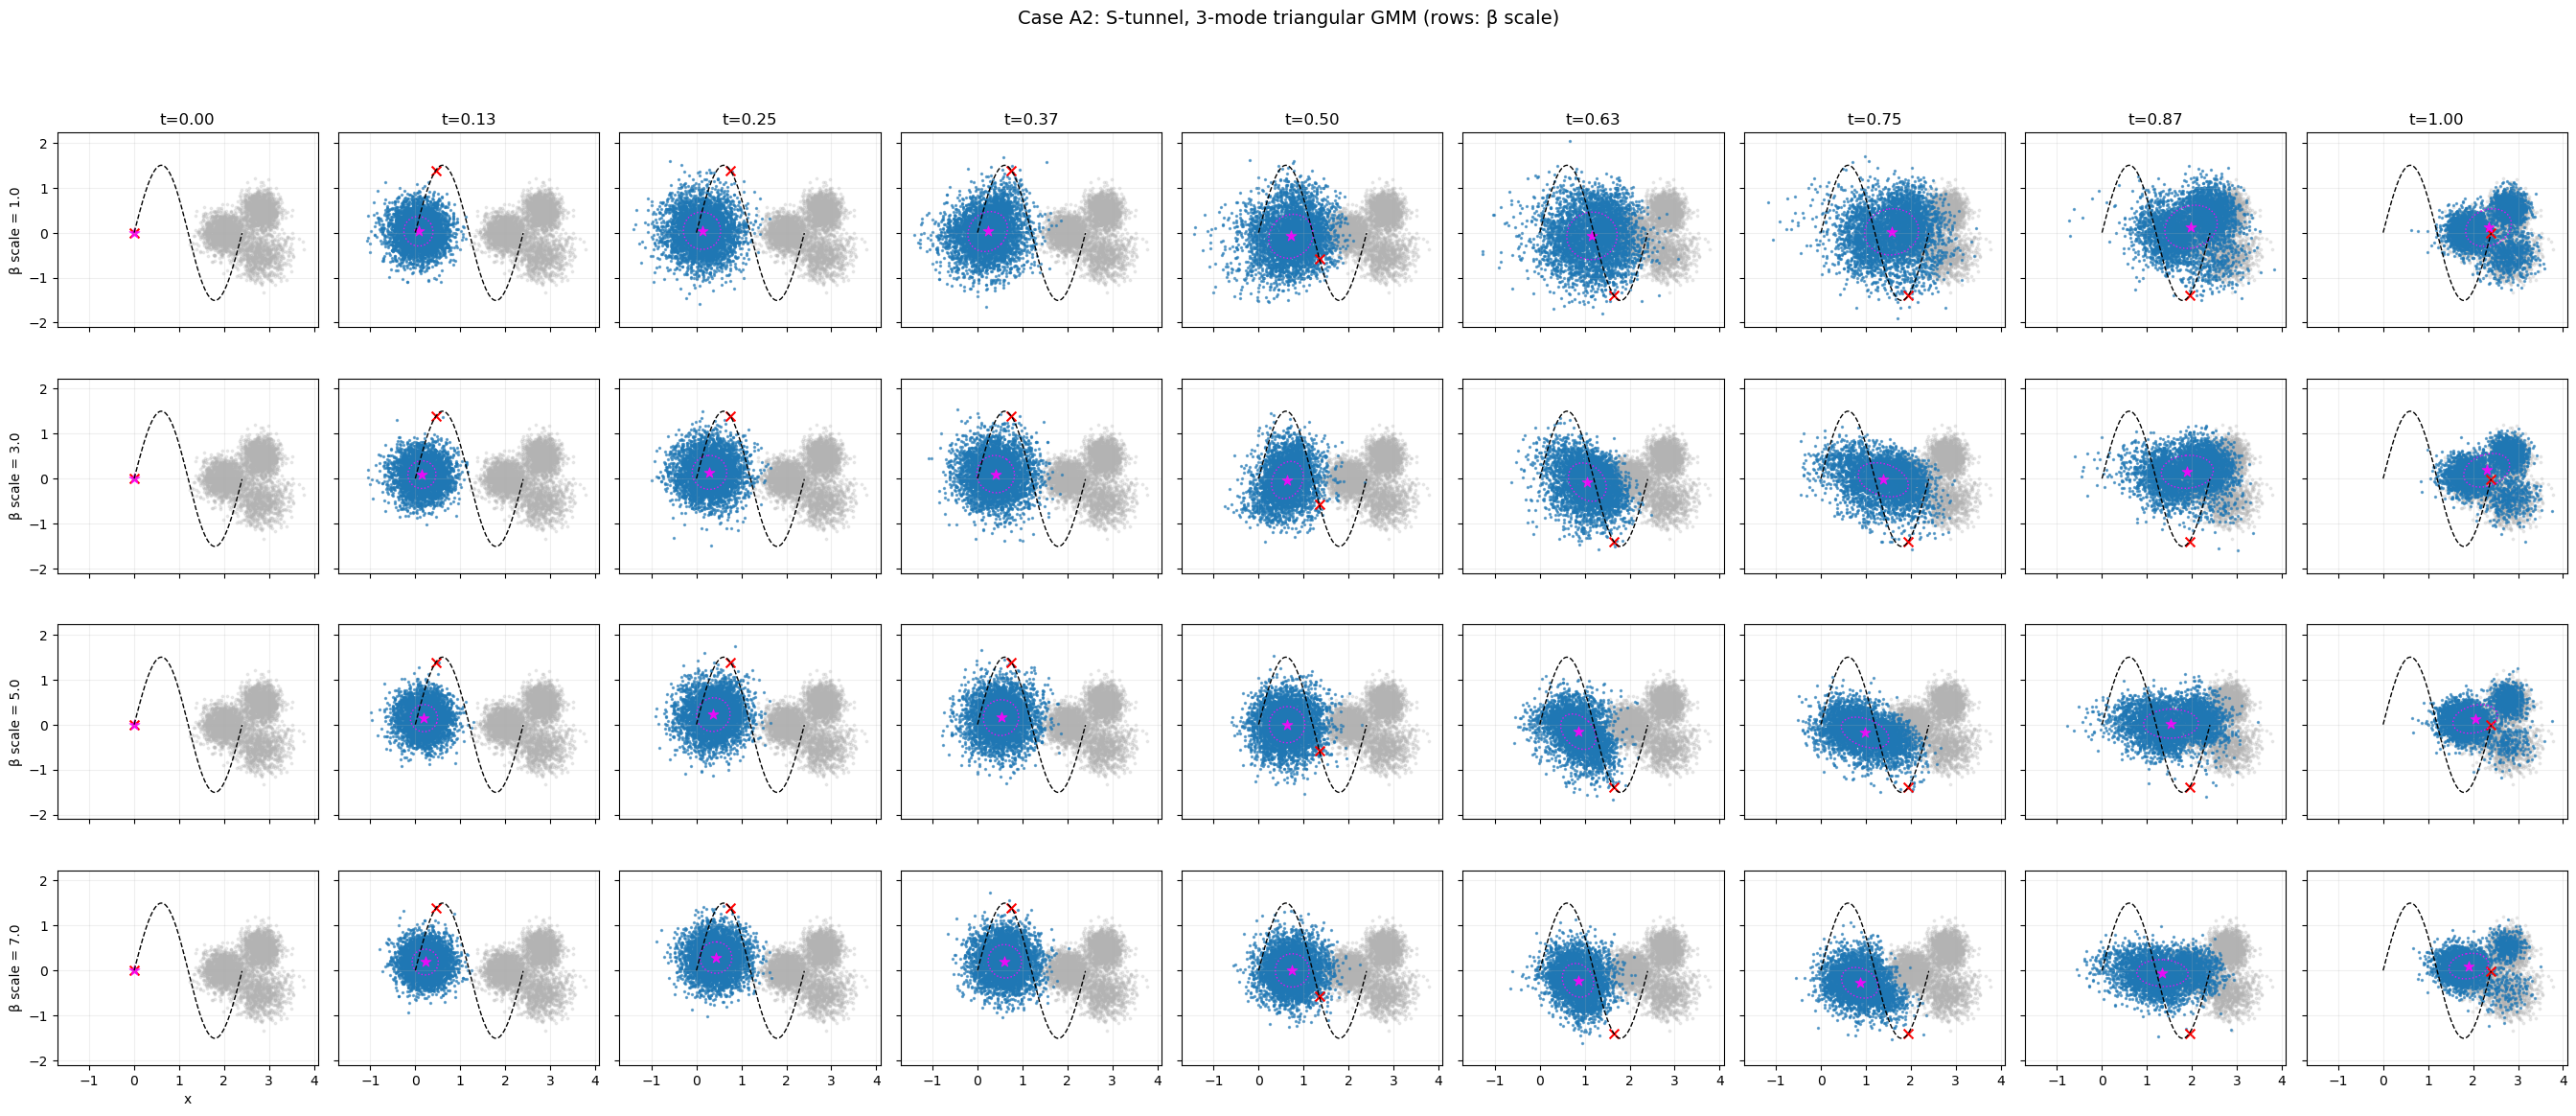

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A2_S_3mode.png


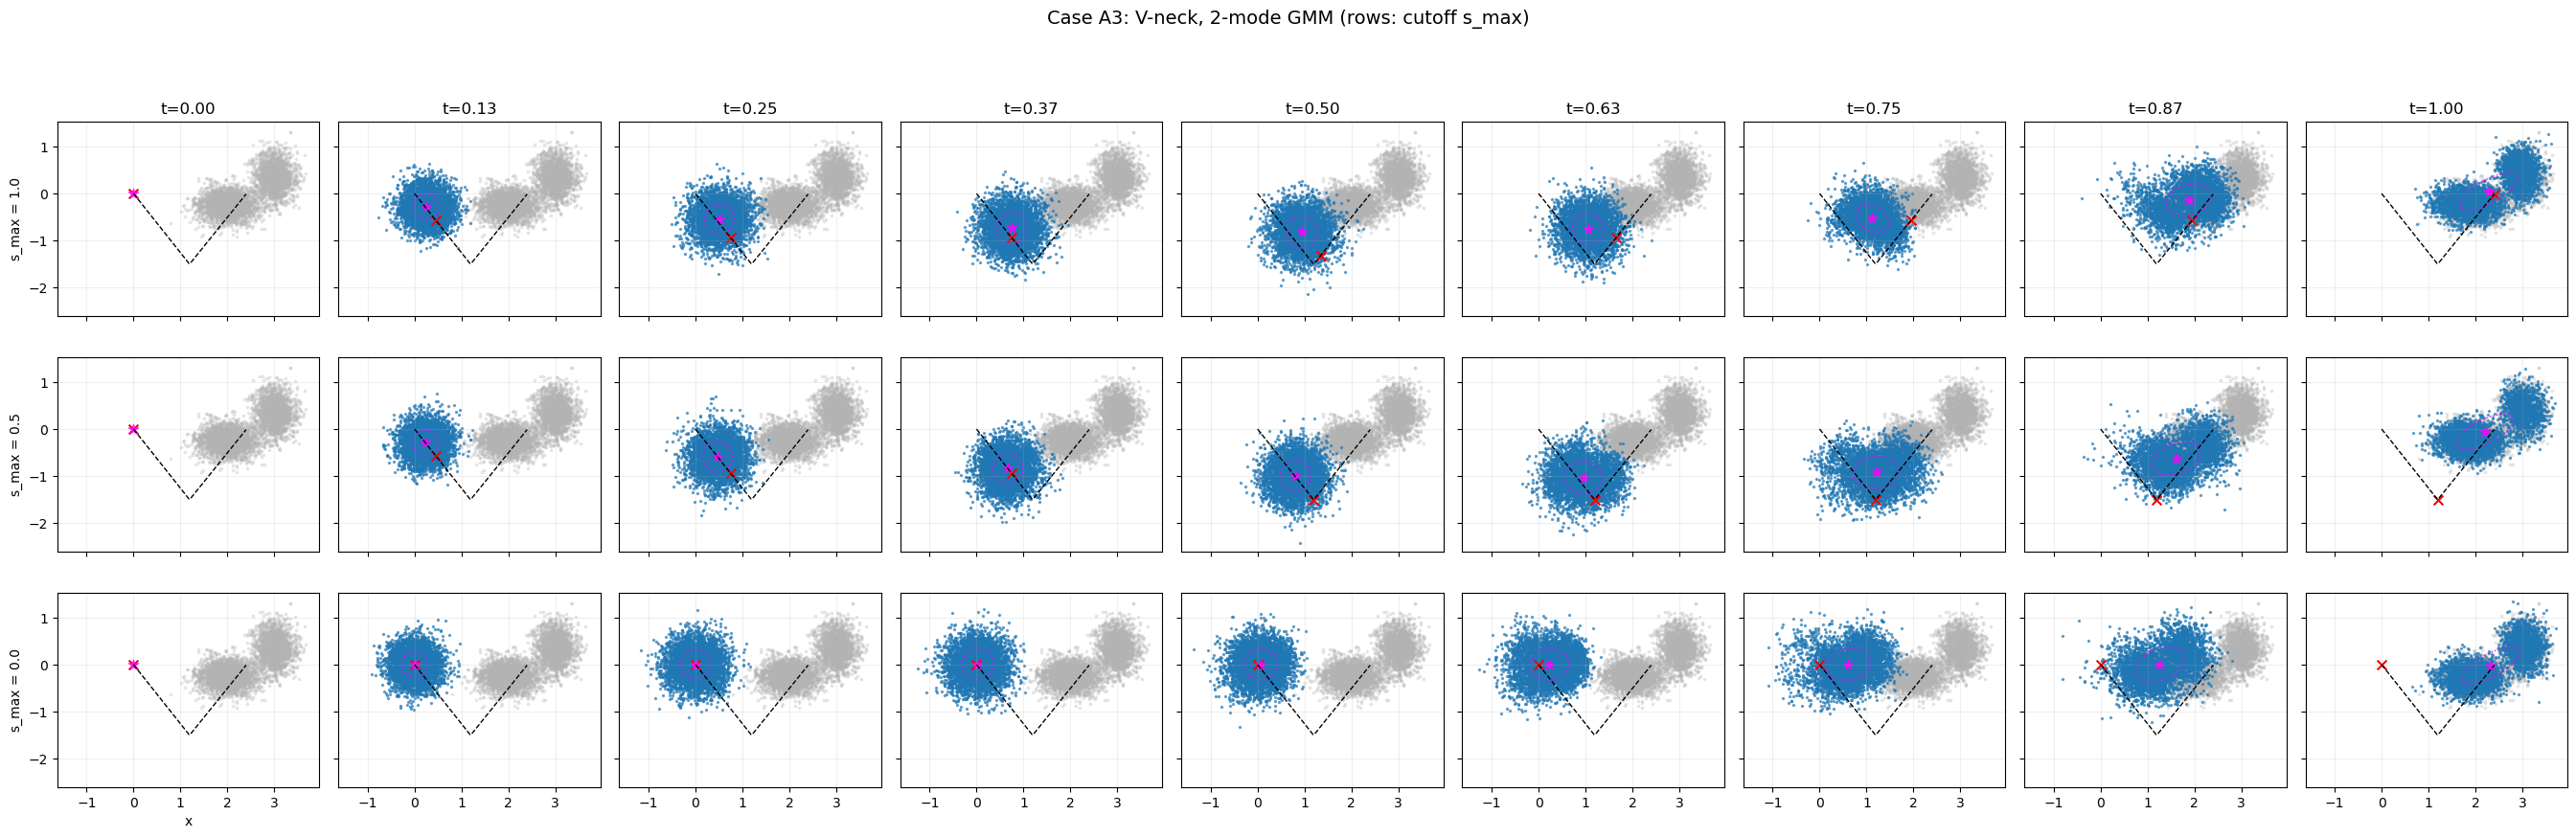

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A3_V_2mode.png


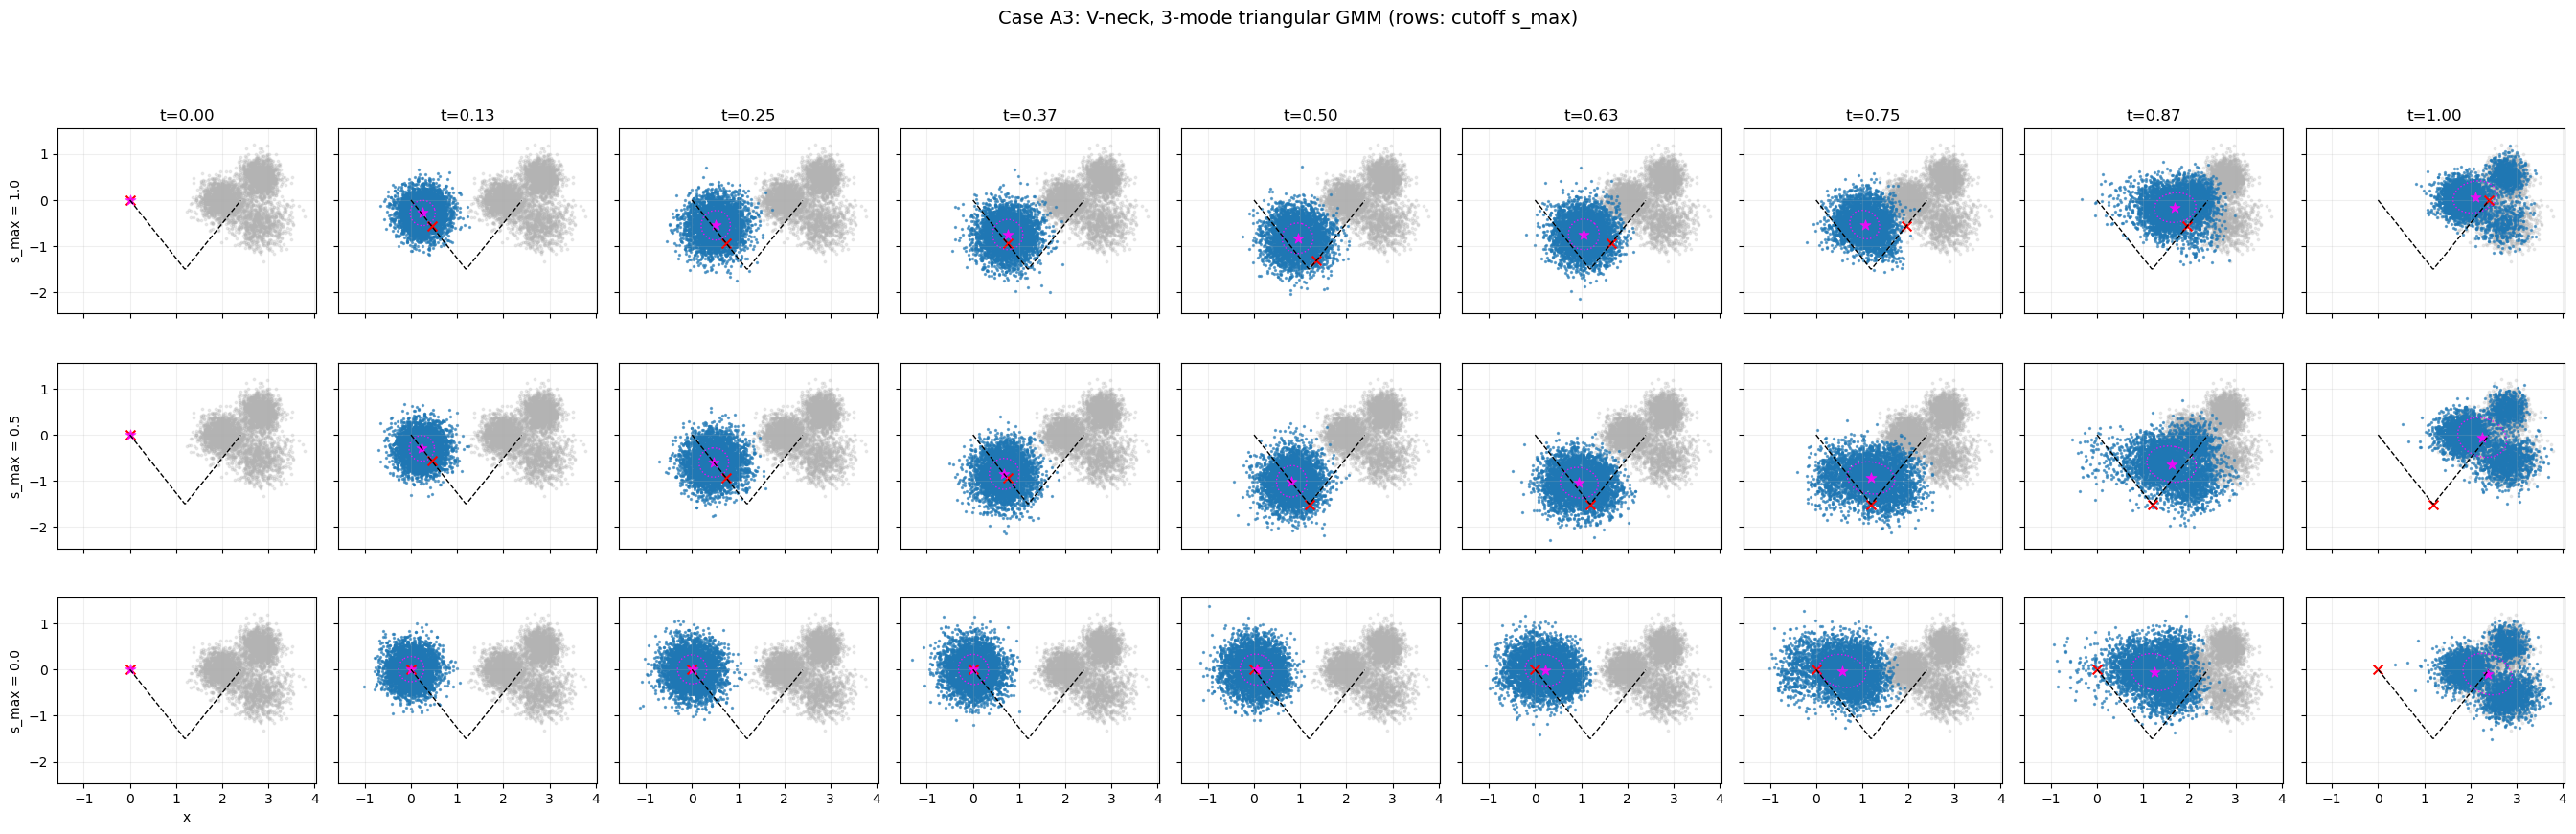

Saved figure to: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/results_caseA/caseA_A3_V_3mode.png


In [33]:
# -----------------------------------------------------------------------------
# 12. Final figures: A1 (geometry), A2 (β), A3 (cutoff s_max)
# -----------------------------------------------------------------------------

snaps_geom_2_rows = [snaps_geom_0["2mode"][g] for g in geom_names]
row_labels_geom   = [f"geometry = {g}" for g in geom_names]
centerlines_geom_rows = [centerline_lin_arr, centerline_v_arr, centerline_s_arr]

plot_snapshots_multirow(
    snaps_geom_2_rows,
    X_tar_2,
    centerline_default=centerline_lin_arr,
    centerlines_by_row=centerlines_geom_rows,
    row_labels=row_labels_geom,
    title_prefix="Case A1: Geometry flexibility (2-mode GMM)",
    filename="caseA_A1_geometry_2mode.png",
)

snaps_geom_3_rows = [snaps_geom_0["3mode"][g] for g in geom_names]

plot_snapshots_multirow(
    snaps_geom_3_rows,
    X_tar_3,
    centerline_default=centerline_lin_arr,
    centerlines_by_row=centerlines_geom_rows,
    row_labels=row_labels_geom,
    title_prefix="Case A1: Geometry flexibility (3-mode triangular GMM)",
    filename="caseA_A1_geometry_3mode.png",
)

snaps_S_2_rows = [snaps_S_0["2mode"][gamma] for gamma in beta_scales_S]
snaps_S_3_rows = [snaps_S_0["3mode"][gamma] for gamma in beta_scales_S]
row_labels_S   = [f"β scale = {gamma:.1f}" for gamma in beta_scales_S]

plot_snapshots_multirow(
    snaps_S_2_rows,
    X_tar_2,
    centerline_default=centerline_s_arr,
    centerlines_by_row=None,
    row_labels=row_labels_S,
    title_prefix="Case A2: S-tunnel, 2-mode GMM (rows: β scale)",
    filename="caseA_A2_S_2mode.png",
)

plot_snapshots_multirow(
    snaps_S_3_rows,
    X_tar_3,
    centerline_default=centerline_s_arr,
    centerlines_by_row=None,
    row_labels=row_labels_S,
    title_prefix="Case A2: S-tunnel, 3-mode triangular GMM (rows: β scale)",
    filename="caseA_A2_S_3mode.png",
)

snaps_V_2_rows = [snaps_V_0["2mode"][c] for c in cutoffs_V]
snaps_V_3_rows = [snaps_V_0["3mode"][c] for c in cutoffs_V]
row_labels_V   = [f"s_max = {c:.1f}" for c in cutoffs_V]

plot_snapshots_multirow(
    snaps_V_2_rows,
    X_tar_2,
    centerline_default=centerline_v_arr,
    centerlines_by_row=None,
    row_labels=row_labels_V,
    title_prefix="Case A3: V-neck, 2-mode GMM (rows: cutoff s_max)",
    filename="caseA_A3_V_2mode.png",
)

plot_snapshots_multirow(
    snaps_V_3_rows,
    X_tar_3,
    centerline_default=centerline_v_arr,
    centerlines_by_row=None,
    row_labels=row_labels_V,
    title_prefix="Case A3: V-neck, 3-mode triangular GMM (rows: cutoff s_max)",
    filename="caseA_A3_V_3mode.png",
)